## Example workflow for spatial exposure time with dorado
#### Caitlin R. R. Turner, July 2025

This workbook provides an example workflow for calculating exposure time in two dimensions using walk-data outputs from dorado. To demonstrate this functionality, the workbook walks through calculations of **spatial water exposure time** for the **Lake Pontchartrain Estuary** in Louisiana (USA). 

To use this notebook, we need `walk_data` and `model_variables` that can be created created using `unstructured_grid_Delft3dFM.ipynb` or can be found [here](https://doi.org/10.4211/hs.2301e151c62d4febb59655885458ab0c) (Turner, 2025) in the folder **D3DFM_example_required_files**. 

For your own implementation with other models, walk_data, elevation (rasterized), exposure time, and regions can be created using `dorado.particle_track.py` and `dorado.routimes.py` following the methods of `unstructured_grid_Delft3dFM.ipynb` or `unstructured_grid_anuga.ipynb`. 

### Import necessary dependencies

In [1]:
import os
import numpy as np
import json
from pathlib import Path
import dorado
from matplotlib import pyplot as plt
import dorado.spatial as spat
import dorado.particle_track as pt

### Set up model names and folders
First, we begin by calling the folder where *dorado* outputs and HydroShare files were saved.

In [2]:
data_folder = Path(r"Documents/D3DFM_example_required_files") # Change to your path
model_run = "run_01"

path2folder = data_folder / model_run
path2folder.mkdir(parents=True, exist_ok=True)

### Load Variables

Now we load walk data that was output by `dorado.particle_track()` as well as variables that were created while running the Delft3D unstructured grid notebook (`unstructured_grid_Delft3dFM.ipynb`). These are the rasterized versions of variables.

- `walk_data` dictionary of all x and y locations and travel times (`xinds`, `yinds`, `travel_times`) created with `dorado.particle_track.py` and `dorado.routimes.py`
- `elevation` terrain or bathymetry grid which is used to define domain shape
- `regions` binary mask that can be created using as a .csv as explained in `unstructured_grid_Delft3dFM.ipynb` that should have the same shape as elevation (1 = region of interest, 0 = ignore).


In [3]:
with open(data_folder / f'WalkData_{model_run}.txt', 'r') as f:
    walk_data = json.load(f)
model_variables = np.load(data_folder / f'unstructured_model_Delft3DFM_variables_{model_run}.npz')
elevation = model_variables['elevation']
regions = model_variables['regions']  # If data was downloaded from HydroShare, you may need to change this to: regions = model_variables['celltype'] 

Now we are going to use `dorado.particle_track.exposure_time()` to calculate exposure time for all particles and create `exposure_times` using `walk_data` and `regions`.

In [ ]:
exposure_times = pt.exposure_time(walk_data, regions)

If you recall, exposure time calculates the amount of time it takes for particles to leave a region of interest (ROI), including excursions. To visualize this, we are going to look at a familar plot, the Cumulative Exposure Time Distribution.



We are going to make an addition to this plot by toggling `show_thresholds` to `True`. This will print out and display lines on the CDF plot that show the time it takes for particles to reach the following three thresholds:
- $E_{50}$: the time it takes for 50% of particles to leave the ROI
- $E_{75}$: the time it takes for 75% of particles to leave the ROI
- $E_{90}$: the time it takes for 90% of particles to leave the ROI



Saving files in existing directory
E50: 15.3 [day]
E75: 18.3 [day]
E90: 23.4 [day]


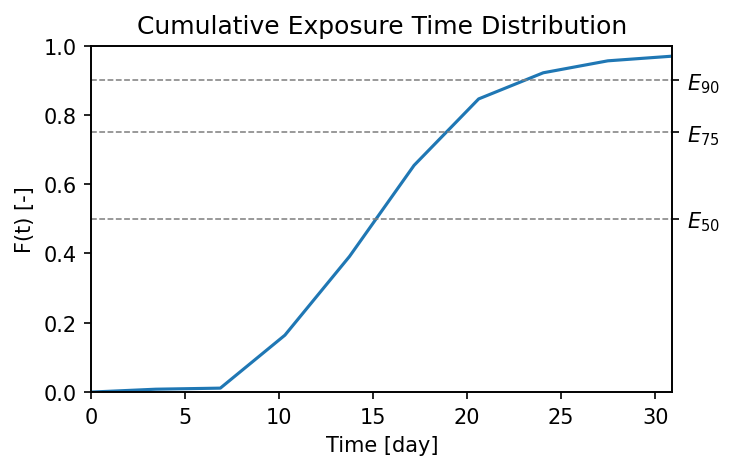

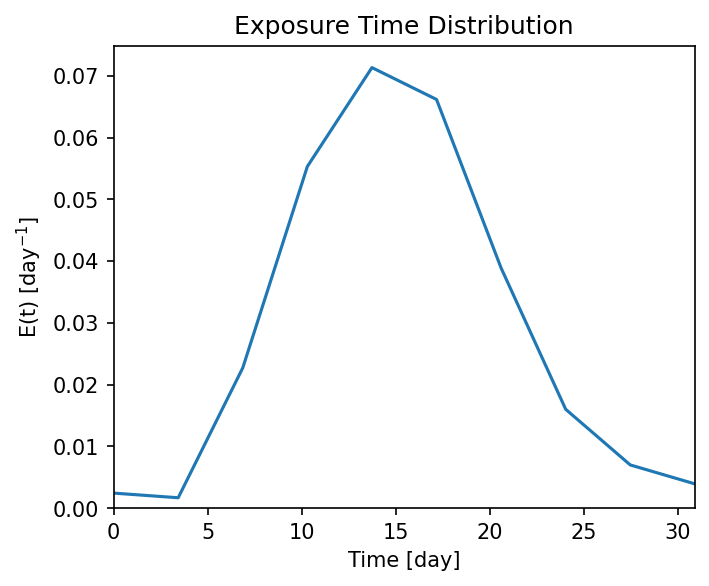

In [5]:
timedelta = 86400 # timestep of random walk in seconds
exposure_times_plot = dorado.routines.plot_exposure_time(walk_data, 
                                                         exposure_times,
                                                         f'{path2folder}/{model_run}/figs',
                                                         timedelta=timedelta, # timestep for model in seconds (1 day = 86400 seconds)
                                                         nbins=10, # Binning for CDF exposure time
                                                         uniform_timesteps = True, # This should be toggled to 'True' when the process used in this notebook for unsteady data is used. Only toggle this if exposure timesteps were discretely assigned. Otherwise use default (False).
                                                         show_thresholds=True) # Toggle this to view exposure time thresholds


We see that it takes 15 days to reach $E_{50}$, 18 days to reach $E_{75}$, and 23 days to reach $E_{90}$. 

## System-Wide Exposure Time
Now that we know the exposure time for all of Lake Pontchartrain as one region of interest (ROI), we want to find how this varies spatially throughout the system. We can do this by creating a grid over all of Lake Pontchartrain (chunks) and finding $E_{50}$, $E_{75}$, and $E_{90}$ the exposure time for particles that began in these chunks, which we call system-wide exposure time. 

System-wide exposure time, shown by the schematic in Figure 1, is the cumulative amount of time it takes for a particle in one `chunk` of Lake Pontchartrain to exit the sytem, which we define by:
- `initial particle locations` defines the starting location of particles, which are the chunks in this example
- `region of interest (ROI)` where we are adding up particle exposure time, in this instance, Lake Pontchartrain

<center><figure>
<img src="schematic_transport_times_system-wide.png" class="bg-primary mb-1" width="500px", align = "center">
<figcaption align = "center"> Figure 1. System-wide exposure time schematic. </figcaption>
</figure><center>


#### Resolution Factor
To find system-wide exposure time, we first need to create these chunks. Finding the exposure time for each rasterized cell is computationally expensive, therefore, we want to provide a `resolution_factor`, which is how much we want to rasterize by. For this example, our grid has 795 columns and 429 rows (795, 429), which would take a long time to run! Our `resolution_factor` reduces the size of each grid. 

Let's say our resolution factor is 60 (`resolution_factor = 60`). This means that each chunk has $60$ **x** $60$ cells, with the exception of the last row and column, which may have less if the actual grid resolution is not divisible by this factor. Keep this in mind when interpreting figures. For this model, the truncated row and column are outside of the (ROI), so it does not impact our results or interpretations.  

Original grid Size: (795, 429)
Rasterized grid Size: (14, 8)


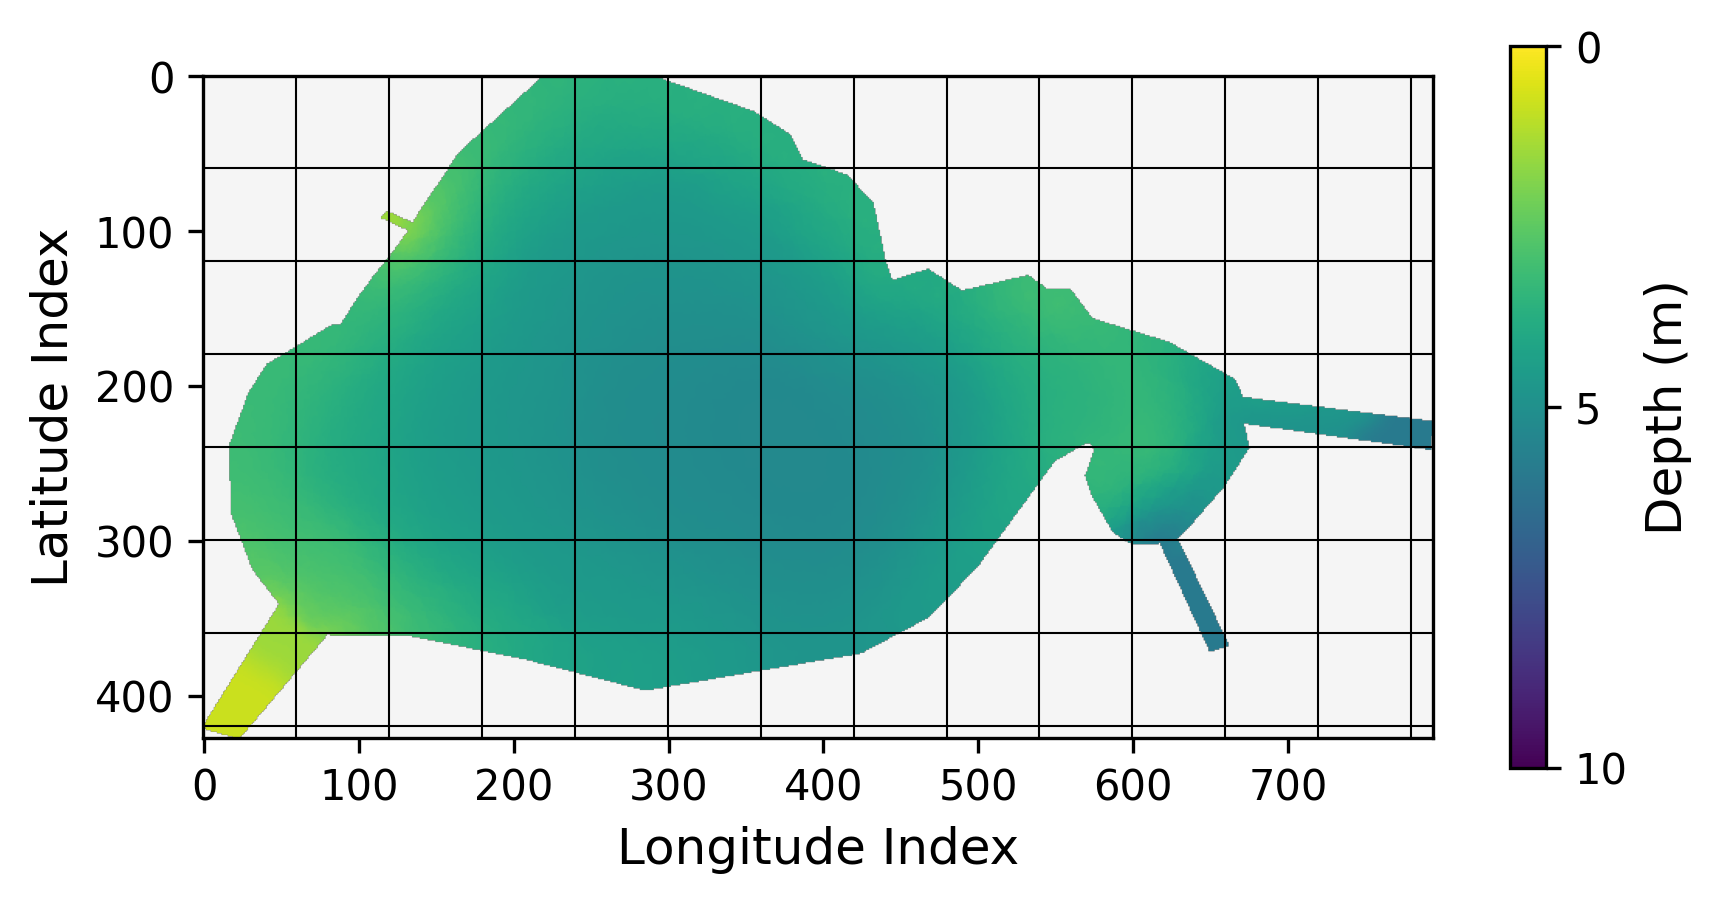

In [6]:
resolution_factor = 60
rows, cols = elevation.shape
print(f'Original grid Size: ({cols + 1}, {rows + 1})') # 1 is added due to give accurate dimensions (a product of zero indexing)
n_chunks_rows = rows // resolution_factor
n_chunks_cols = cols // resolution_factor
print(f'Rasterized grid Size: ({n_chunks_cols + 1}, {n_chunks_rows + 1})') # 1 is added due to give accurate dimensions (a product of zero indexing)

# Figure to Visualize
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
cax = ax.imshow(elevation, vmin=-10, vmax=0, cmap='viridis')
cbar = fig.colorbar(cax, ax=ax, label='Depth (m)', shrink=0.65)
cbar.ax.set_ylabel('Depth (m)', fontsize=12)
cbar.set_ticks([0, -5, -10])
cbar.set_ticklabels(['0', '5', '10'])
ax.set_xlabel('Longitude Index', fontsize=12)
ax.set_ylabel('Latitude Index', fontsize=12)
ax.set_facecolor('whitesmoke')
for y in range(0, rows, resolution_factor):
    ax.axhline(y - 0.5, color='black', linewidth=0.5)
for x in range(0, cols, resolution_factor):
    ax.axvline(x - 0.5, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()


We had an original grid size with 795 columns and 429 rows that we reduced to 14 columns and 8 rows.

These chunks are a little large, let's try a finer resolution. To do this, we want to decrease the resolution factor.
Let's try a resolution factor of 30 (`resolution_factor = 30`). 

Original grid Size: (795, 429)
Rasterized grid Size: (39, 21)


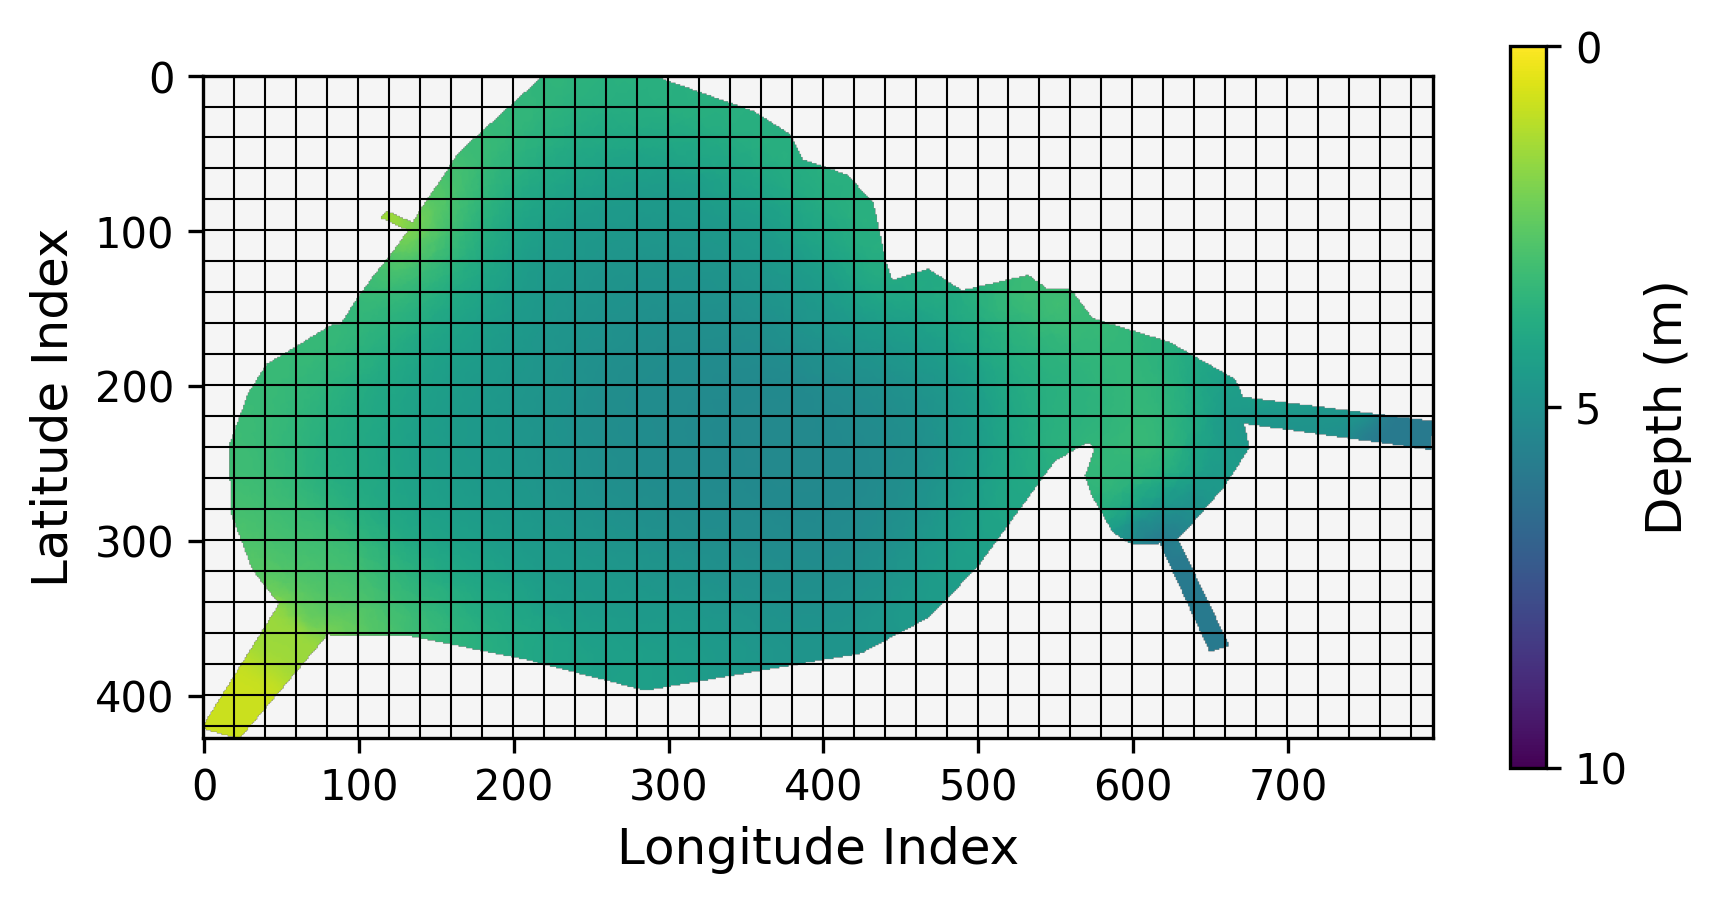

In [7]:
resolution_factor = 20
rows, cols = elevation.shape
print(f'Original grid Size: ({cols + 1}, {rows + 1})') # 1 is added due to give accurate dimensions (a product of zero indexing)
n_chunks_rows = rows // resolution_factor
n_chunks_cols = cols // resolution_factor
print(f'Rasterized grid Size: ({n_chunks_cols}, {n_chunks_rows})') # 1 is added due to give accurate dimensions (a product of zero indexing)

# Figure to Visualize
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
cax = ax.imshow(elevation, vmin=-10, vmax=0, cmap='viridis')
cbar = fig.colorbar(cax, ax=ax, label='Depth (m)', shrink=0.65)
cbar.ax.set_ylabel('Depth (m)', fontsize=12)
cbar.set_ticks([0, -5, -10])
cbar.set_ticklabels(['0', '5', '10'])
ax.set_xlabel('Longitude Index', fontsize=12)
ax.set_ylabel('Latitude Index', fontsize=12)
ax.set_facecolor('whitesmoke')
for y in range(0, rows, resolution_factor):
    ax.axhline(y - 0.5, color='black', linewidth=0.5)
for x in range(0, cols, resolution_factor):
    ax.axvline(x - 0.5, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()


We have a an original grid size with 795 columns and 429 rows that we reduced to 26 columns and 14 rows. This is a lot finer and will help us capture spatial variablility.

#### System-wide Exposure Time Calculation
Now that we have the resolution we desire, we are going to calcuate system-wide exposure time. We need the imput the following variables:
`walk_data`, `elevation`, `regions`, and `resolution_factor`.

This function `dorado.spatial.systemwide()` which identifies particles began in each chunk, and tracks them until they leave Lake Pontchartrain (ROI) using `dorado.particle_track.exposure_time()`. This returns a list of exposure times for each particle that began in that chunk.

In [ ]:
systemwide_exposure = spat.systemwide(walk_data, elevation, regions, resolution_factor = resolution_factor)

Now that we have a list of exposure times for particles in each chunk, we want to find how long it takes for particles to reach our three thresholds ($E_{50}$, $E_{75}$, $E_{90}$). The function `dorado.spatial.compute_thresholds()` calculates these thresholds, then puts them into a gridded array to match the shape of `elevation` file, creating a spatial map. 

We are going to smooth out this spatial map using a Mean Average Deviation filter.

We need to define two variables:
- `Window Size` Number of adjacent gridcells used to smooth data
- `Threshold` Number of gridcells used to supress outliers

Additionally, we input `exposure_data`, `elevation`, `timedelta`, and `resolution_factor`, which will output three 2D arrays of exposure time data for our thresholds: `E50_sys`, `E75_sys`, and `E90_sys`.

In [9]:
window_size = 5
threshold = 5

In [10]:
E50_sys, E75_sys, E90_sys = spat.compute_thresholds(
    exposure_data=systemwide_exposure,
    elevation=elevation,
    timedelta=timedelta,
    resolution_factor=resolution_factor,
    window_size=window_size,
    threshold=threshold)

#### System-wide Exposure Time Figure
Now that we have our three spatial arrays, we are going to plot them. Here we are going to define a few variables:
- `title` the label on the colorbar
- `cmap` the colormap we want to use. In this example, we use a matplotlib colormap; however, [cmocean](https://matplotlib.org/cmocean/) is another colorbar that is great for this application.
- `max_exposure` the maximum time we want the colorbar to go to. For system-wide exposure time, your maximum model time is a good starting point. For this example, the maximum possible exposure time is 30 days (the timeframe of the model).
- `cbar_levels` the number of levels we want to split the colorbar by.

In [11]:
title = 'System-wide exposure time (days)'
cmap = plt.get_cmap('plasma_r')
max_exposure = 30 # max time in model
cbar_levels = 7

In addition to these variables, we will enter `E50_sys`, `E75_sys`, `E90_sys`, and `elevation`.

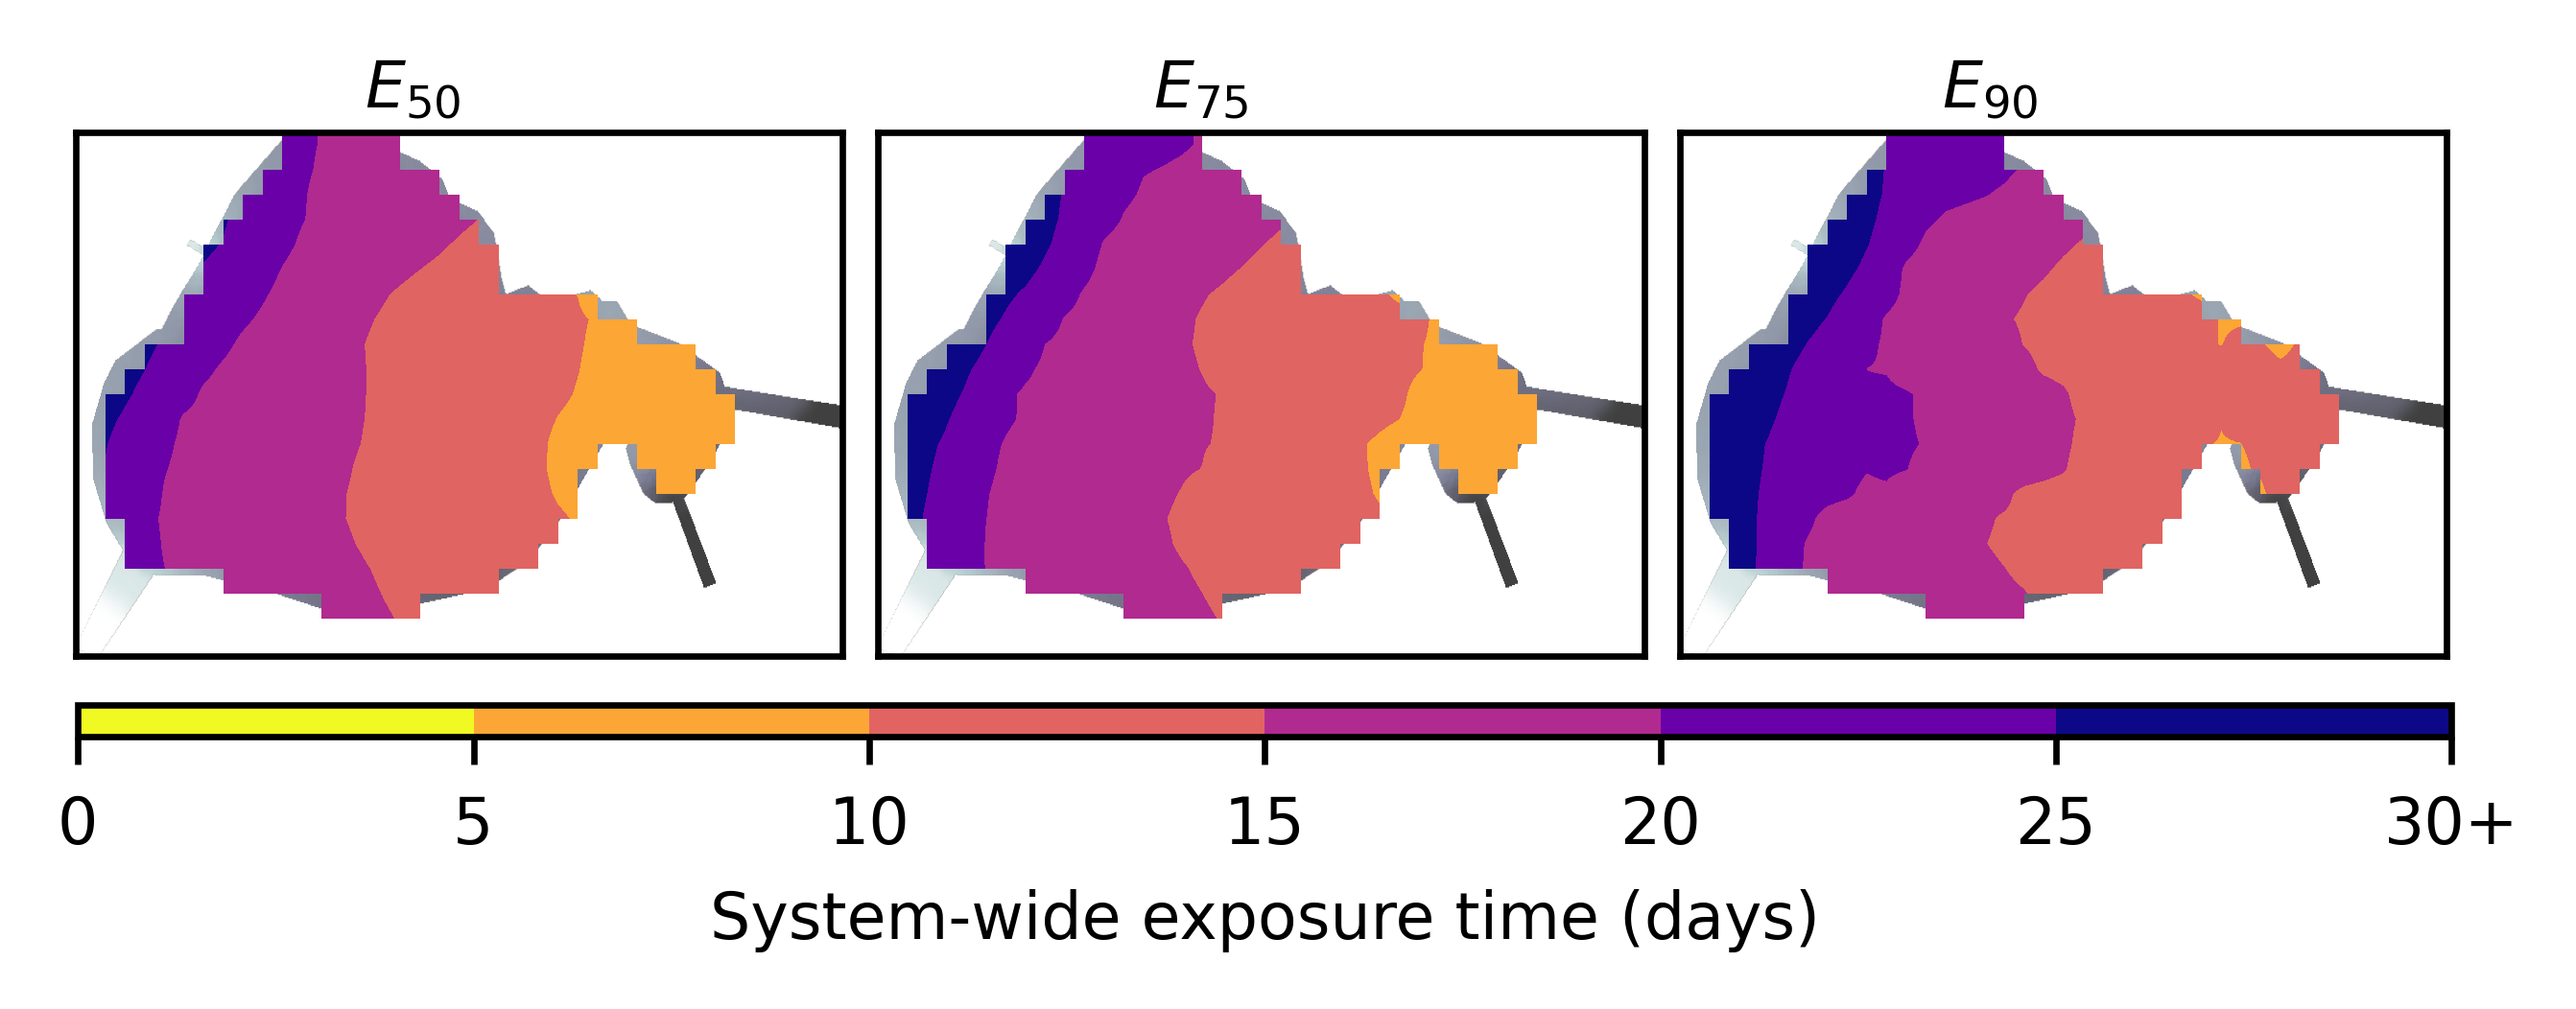

In [19]:
systemwide_plot = spat.plot_spatial(exposure_maps=[E50_sys, E75_sys, E90_sys],
                                        elevation=elevation,
                                        max_exposure=max_exposure,
                                        cbar_levels=cbar_levels,
                                        cmap=cmap,
                                        title=title)


This figure shows longer exposure times furthest from the ocean boundary, which is what we would expect! 

We are able to see how long it takes for water from exit the system from different locations. What if we want to see how long water starting in one of those locations, remains in that location? We call this `localized exposure time`.

(**Note:** If additional edge smoothing and preservation is desired, the creation of a mesh grid coupled with `matplotlib.contourf()` may be used instead of `matplotlib.imshow()` in the `spat.plot_spatial()` can be used.)

## Localized Exposure Time
Localized exposure time, shown by the schematic in Figure 2, is the cumulative amount of time it takes for a particle in one `chunk` of Lake Pontchartrain to exit the sytem, which we define by:
- `initial particle locations` defines the starting location of particles, which are the chunks in this example
- `region of interest (ROI)` where we are adding up particle exposure time, in this instance, we are using those same chunks

This helps us quanitfy how long particles may remain in one particular area.

<center><figure>
<img src="schematic_transport_times_localized.png" class="bg-primary mb-1" width="500px", align = "center">
<figcaption align = "center"> Figure 2. Localized exposure time schematic. </figcaption>
</figure><center>

#### Resolution Factor and Localized Exposure Time Calculation
Here we are keeping the same `resolution_factor` that we used for system-wide exposure time.

In [ ]:
localized_exposure = spat.localized(walk_data, elevation, regions, resolution_factor = resolution_factor)

We are keeping the same smoothing parameters, but if you would like to change them, we can redefine them here.

In [14]:
window_size = 5
threshold = 5

In [15]:
E50_local, E75_local, E90_local = spat.compute_thresholds(
                                                exposure_data=localized_exposure,
                                                elevation=elevation,
                                                timedelta=timedelta,
                                                resolution_factor=resolution_factor,
                                                window_size=window_size,
                                                threshold=threshold)

#### Localized Exposure Time Figure
In previous studies using this method, localized exposure times were smaller than system-wide, therefore, we can change the max exposure times for our colorbar. This makes it easy to test different numbers to see what best displays our data.

In [16]:
title_local = 'Localized exposure time (days)'
cmap_local = plt.get_cmap('viridis_r')
max_exposure_local = 7
cbar_levels_local = 6

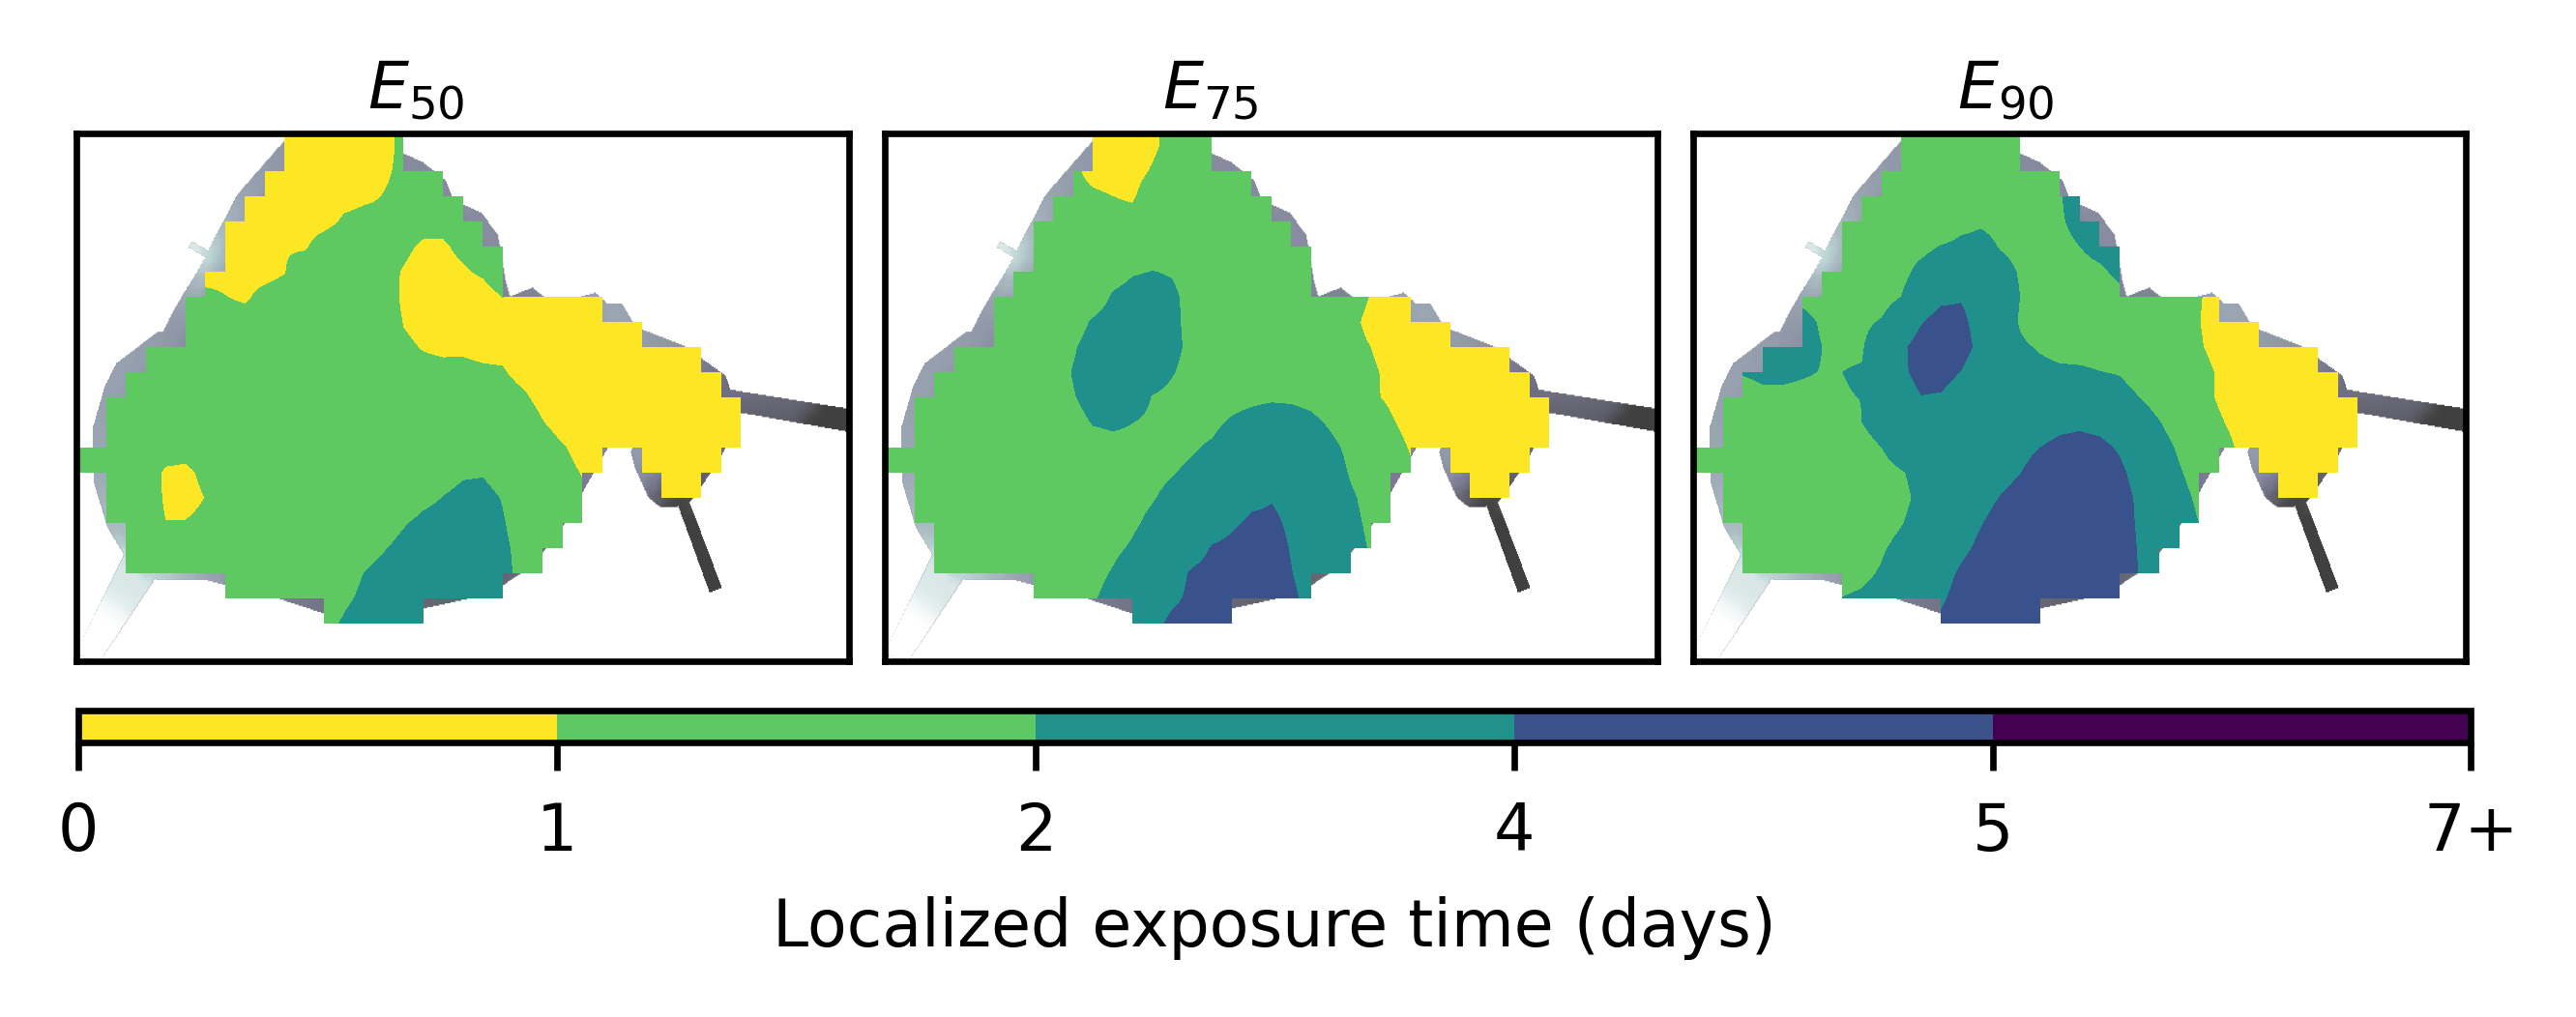

In [18]:
localized_plot = spat.plot_spatial(
                            exposure_maps=[E50_local, E75_local, E90_local],
                            elevation=elevation,
                            max_exposure=max_exposure_local,
                            cbar_levels=cbar_levels_local,
                            cmap=cmap_local,
                            title=title_local)

As you can see, our exposure time values are much lower than system-wide. This makes sense! Localized exposure times should be lower, as we are only quantifying how long these particles remain in these chunks.
Additioanlly, we are seeing zones of increased exposure time, essentailly, areas where localized flows trapped particles. 

If you have any questions or need help with implementation to your model, please do not hesitate to contact Caitlin R. R. Turner at cturn65@lsu.edu 

#### **Cited**:
Turner, C. R. R. (2025). Lake Pontchartrain Toy Model, HydroShare, https://doi.org/10.4211/hs.2301e151c62d4febb59655885458ab0c

Turner, C. R. R., & Hiatt, M. (2025a). Water exposure time distributions controlled by freshwater releases in a semi-enclosed estuary. Water Resources Research, 61 (7), e2025WR040287, https://doi.org/10.1029/2025WR040287

Turner, C. R. R., & Hiatt, M. (2025b). Water exposure time distributions controlled by freshwater releases in a semi-enclosed estuary published in water resources research wrr 2025 data [Dataset]. Hydroshare. https://doi:10.4211/hs.f1c83ff830bb47c5a7c84e6f5217ea5c

#### **Acknowledgments:**
This work has been partially supported with funding provided by the Louisiana Sea Grant College Program (LSG) under its Competitive Research Program (Project ID: R/TMA-03) and NOAA Award No. NA18OAR4170098, and through the US Department of Defense/Army Engineer Research and Development Center (ERDC) under Contract No. W912HZ2220005. Additional support was provided from the National Science Foundation (NSF) through Open Earthscape (Collaborative Research: Frameworks: OpenEarthscape - Transformative Cyberinfrastructure for Modeling and Simulation in the Earth-Surface Science Communities) under its Summer Research Scholars Program under award No. 2104102.